## Data generation

In [1]:
import csv
import os
from typing import List, Tuple
import numpy as np
from numpy.typing import NDArray
from qutip import Qobj, bell_state, qzero, sigmax, sigmay, sigmaz, tensor
from sklearn.preprocessing import MinMaxScaler


def bell_diagonal_density_matrix() -> Tuple[Qobj, int]:
    """Produces a density matrix for a diagonal Bell state

    Returns:
        Qobj: The density matrix
        int: 1 if the state is separable, -1 otherwise
    """

    p = np.random.random(4)
    p = p / np.sum(p)

    dm = qzero([2, 2])
    names = ["00", "01", "10", "11"]
    for i, name in enumerate(names):
        bell = bell_state(state=name)  # type: ignore
        bell_dm = bell @ bell.dag()
        dm += p[i] * bell_dm

    separable = 1 if np.max(p) <= 1 / 2 else -1
    return dm, separable


def pauli_measurements(dm: Qobj) -> List:
    measurements = []
    for op in [sigmax(), sigmay(), sigmaz()]:
        measurements.append(((dm @ tensor(op, op)).tr().real))
    return measurements


def scale_data(measurements) -> NDArray:
    """Scale the data to match a phase in range [0, 2*pi]"""
    arr = np.array(measurements)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(arr[:, :-1]) * 2 * np.pi
    scaled[np.abs(scaled) < 0.000001] = 0.0
    return np.insert(scaled, scaled.shape[1], arr[:, -1], axis=1)


np.random.seed(42)

filepath = os.path.join(os.path.dirname(os.getcwd()), f"data_bell.csv")
if not os.path.exists(filepath):
    print("fa")
    rows = []
    for _ in range(5000):
        dm, separable = bell_diagonal_density_matrix()
        row = pauli_measurements(dm)
        row.append(separable)
        rows.append(row)

    rows = scale_data(rows)

    with open(filepath, "w") as f:
        csv_writer = csv.writer(f)
        header = ["XX", "YY", "ZZ", "separable"]
        csv_writer.writerow(header)
        csv_writer.writerows(rows)


## Loading and visualising data

In [2]:
import polars as pl


df = pl.read_csv("../data_bell.csv")
    
df = df.with_columns(
    pl.col("separable").cast(pl.Int64)
)

X = df["XX", "YY", "ZZ"]
y = df["separable"]

df.describe()


statistic,XX,YY,ZZ,separable
str,f64,f64,f64,f64
"""count""",5000.0,5000.0,5000.0,5000.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",3.160067,3.134384,3.164935,0.6656
"""std""",1.037626,1.029752,1.037287,0.746383
"""min""",0.0,0.0,0.0,-1.0
"""25%""",2.468675,2.489043,2.493056,1.0
"""50%""",3.166035,3.130618,3.15951,1.0
"""75%""",3.836789,3.80242,3.826115,1.0
"""max""",6.283185,6.283185,6.283185,1.0


Rank of the feature matrix: 3


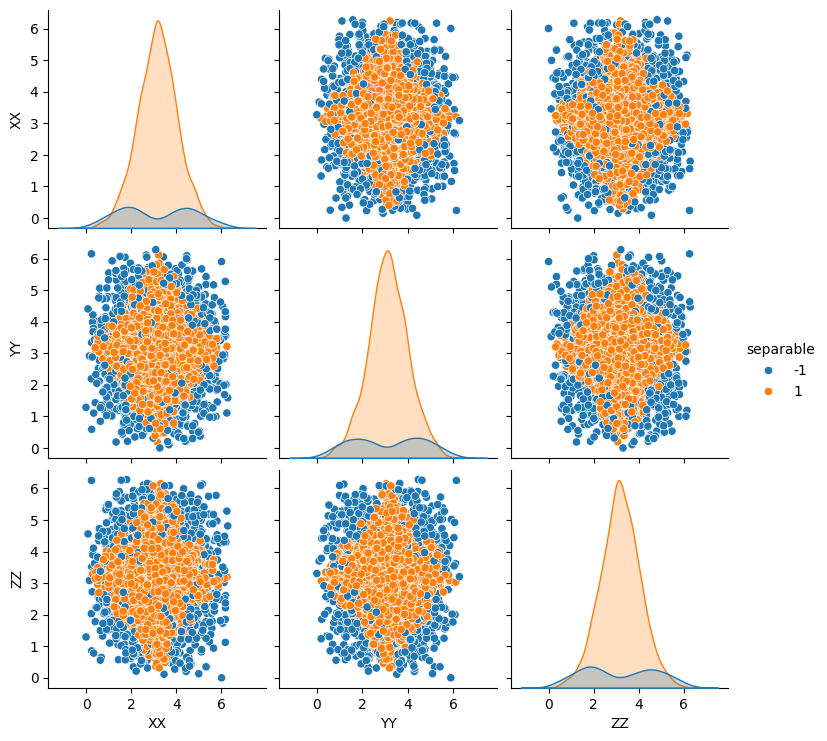

In [3]:
import seaborn as sns


pdf = df.to_pandas()
print("Rank of the feature matrix:", np.linalg.matrix_rank(X.to_numpy()))
sns.pairplot(pdf, hue="separable", palette="tab10")


## Defining and training the model

In [4]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import real_amplitudes, zz_feature_map
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split


qubits = X.shape[1]

feature_map = zz_feature_map(feature_dimension=qubits)
ansatz = real_amplitudes(num_qubits=qubits, reps=3)

qnn_circuit = QuantumCircuit(qubits)
qnn_circuit.compose(feature_map, inplace=True)
qnn_circuit.compose(ansatz, inplace=True)

print(qnn_circuit.draw())

estimator = EstimatorV2()

observable = SparsePauliOp.from_list([("ZII", 1.0), ("IZI", 1.0), ("IIZ", 1.0)])
qnn = EstimatorQNN(
    circuit=qnn_circuit,
    estimator=estimator,
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

qml_classifier = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=COBYLA(maxiter=300),
)

qml_classifier.fit(X_train, y_train)


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


     ┌───┐┌───────────┐                                               »
q_0: ┤ H ├┤ P(2*x[0]) ├──■────────────────────────────────────■────■──»
     ├───┤├───────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├┤ P(2*x[1]) ├┤ X ├┤ P((-π + x[0])*(-π + x[1])*2) ├┤ X ├──┼──»
     ├───┤├───────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ P(2*x[2]) ├──────────────────────────────────────────┤ X ├»
     └───┘└───────────┘                                          └───┘»
«                                          ┌───┐»
«q_0: ──────────────────────────────────■──┤ H ├»
«                                       │  └───┘»
«q_1: ──────────────────────────────────┼────■──»
«     ┌──────────────────────────────┐┌─┴─┐┌─┴─┐»
«q_2: ┤ P((-π + x[0])*(-π + x[2])*2) ├┤ X ├┤ X ├»
«     └──────────────────────────────┘└───┘└───┘»
«              ┌───────────┐                                      »
«q_0: ─────────┤ P(2*x[0]) ├───────────────────────────────────■──»
«         

## Model performance analysis

Accuracy = 0.841
Precision = 0.896


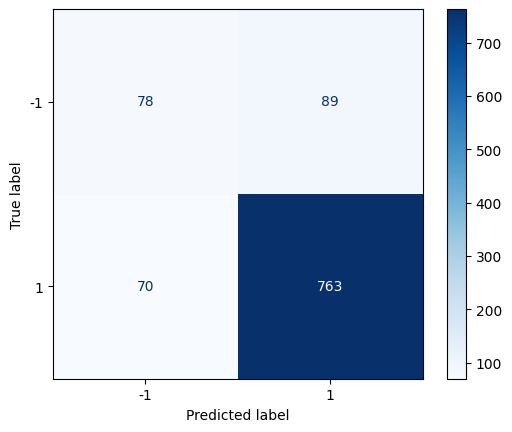

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_pred = qml_classifier.predict(X_test).squeeze(1)
y_true = y_test.to_numpy()

TP = np.sum((y_true == 1) & (y_pred == 1))
FP = np.sum((y_true == -1) & (y_pred == 1))
TN = np.sum((y_true == -1) & (y_pred == -1))
FN = np.sum((y_true == 1) & (y_pred == -1))

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)

print(f"Accuracy = {accuracy:.3f}")
print(f"Precision = {precision:.3f}")

cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap='Blues')


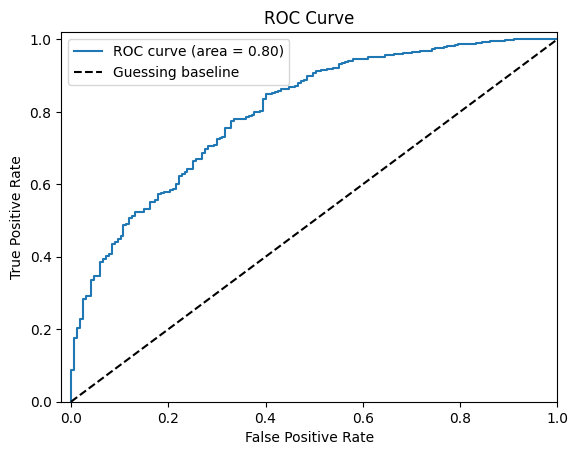

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_probs = qml_classifier.predict_proba(X_test).squeeze(1)

fpr, tpr, thresholds = roc_curve(y_test, y_probs) 
roc_auc = auc(fpr, tpr)

plt.figure()  
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Guessing baseline")
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
